In [16]:
!pip install langchain langchain-google-genai ragas pandas matplotlib

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.evaluation import load_evaluator
from langchain.schema import HumanMessage

In [18]:
os.environ["GOOGLE_API_KEY"] = "Your API Key"

In [19]:
def create_evaluation_dataset():
  """Create a dataset reflecting Handshake's domain."""
  questions = [
        "What are effective strategies for recent graduates to find entry-level positions?",
        "How can I tailor my resume for a software engineering internship?",
        "What should I include in a cover letter for a marketing role?",
        "How do I prepare for a behavioral interview?",
        "What are common mistakes to avoid in a job application?"
    ]

  ground_truth = [
        "Effective strategies include networking, attending career fairs, utilizing job platforms like Handshake, and customizing applications for each role.",
        "Tailor your resume by highlighting relevant coursework, projects, and technical skills pertinent to software engineering.",
        "Include your motivation for the role, relevant experiences, and how your skills align with the company's needs.",
        "Prepare by reviewing common behavioral questions, reflecting on past experiences, and practicing your responses.",
        "Avoid generic applications, neglecting to proofread, and failing to follow application instructions."
    ]

  return pd.DataFrame({"question": questions, "ground_truth": ground_truth})

In [20]:
def setup_models():
  """Set up different Google Genereative AI models for comparison."""
  models = {
      "gemini-2.0-flash-lite": ChatGoogleGenerativeAI(model = "gemini-2.0-flash-lite", temperature=0),
      "gemini-2.0-flash": ChatGoogleGenerativeAI(model = "gemini-2.0-flash", temperature=0)
  }
  return models

In [21]:
def generate_responses(models, dataset):
    """Generate responses from each model for the questions in the dataset."""
    responses = {}

    for model_name, model in models.items():
        model_responses = []
        for question in dataset["question"]:
            try:
                response = model.invoke([HumanMessage(content=question)])
                model_responses.append(response.content)
            except Exception as e:
                print(f"Error with model {model_name} on question: {question}")
                print(f"Error: {e}")
                model_responses.append("Error generating response")

        responses[model_name] = model_responses

    return responses

In [22]:
def evaluate_responses(models, dataset, responses):
    """Evaluate model responses using different evaluation criteria."""
    evaluator_model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite", temperature=0)

    reference_criteria = ["correctness"]
    reference_free_criteria = [
        "relevance",
        "coherence",
        "conciseness"
    ]

    results = {model_name: {criterion: [] for criterion in reference_criteria + reference_free_criteria}
               for model_name in models.keys()}

    for criterion in reference_criteria:
        evaluator = load_evaluator("labeled_criteria", criteria=criterion, llm=evaluator_model)

        for model_name in models.keys():
            for i, question in enumerate(dataset["question"]):
                ground_truth = dataset["ground_truth"][i]
                response = responses[model_name][i]

                if response != "Error generating response":
                    eval_result = evaluator.evaluate_strings(
                        prediction=response,
                        reference=ground_truth,
                        input=question
                    )
                    normalized_score = float(eval_result.get('score', 0)) * 2
                    results[model_name][criterion].append(normalized_score)
                else:
                    results[model_name][criterion].append(0)

    for criterion in reference_free_criteria:
        evaluator = load_evaluator("criteria", criteria=criterion, llm=evaluator_model)

        for model_name in models.keys():
            for i, question in enumerate(dataset["question"]):
                response = responses[model_name][i]

                if response != "Error generating response":
                    eval_result = evaluator.evaluate_strings(
                        prediction=response,
                        input=question
                    )
                    normalized_score = float(eval_result.get('score', 0)) * 2
                    results[model_name][criterion].append(normalized_score)
                else:
                    results[model_name][criterion].append(0)
    return results

In [23]:
def calculate_average_scores(evaluation_results):
    """Calculate average scores for each model and criterion."""
    avg_scores = {}

    for model_name, criteria in evaluation_results.items():
        avg_scores[model_name] = {}

        for criterion, scores in criteria.items():
            if scores:
                avg_scores[model_name][criterion] = sum(scores) / len(scores)
            else:
                avg_scores[model_name][criterion] = 0

        all_scores = [score for criterion_scores in criteria.values() for score in criterion_scores if score is not None]
        if all_scores:
            avg_scores[model_name]["overall"] = sum(all_scores) / len(all_scores)
        else:
            avg_scores[model_name]["overall"] = 0

    return avg_scores

In [24]:
def visualize_results(avg_scores):
    """Visualize evaluation results with bar charts."""
    models = list(avg_scores.keys())
    criteria = list(avg_scores[models[0]].keys())

    plt.figure(figsize=(14, 8))

    bar_width = 0.8 / len(models)

    positions = range(len(criteria))

    for i, model in enumerate(models):
        model_scores = [avg_scores[model][criterion] for criterion in criteria]
        plt.bar([p + i * bar_width for p in positions], model_scores,
                width=bar_width, label=model)

    plt.xlabel('Evaluation Criteria', fontsize=12)
    plt.ylabel('Average Score (0-10)', fontsize=12)
    plt.title('LLM Model Comparison by Evaluation Criteria', fontsize=14)
    plt.xticks([p + bar_width * (len(models) - 1) / 2 for p in positions], criteria)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))

    categories = [c for c in criteria if c != 'overall']
    N = len(categories)

    angles = [n / float(N) * 2 * 3.14159 for n in range(N)]
    angles += angles[:1]

    plt.polar(angles, [0] * (N + 1))
    plt.xticks(angles[:-1], categories)

    for model in models:
        values = [avg_scores[model][c] for c in categories]
        values += values[:1]
        plt.polar(angles, values, label=model)

    plt.legend(loc='upper right')
    plt.title('LLM Model Comparison - Radar Chart', fontsize=14)
    plt.tight_layout()
    plt.show()

In [25]:
def main():
    print("Creating evaluation dataset...")
    dataset = create_evaluation_dataset()

    print("Setting up models...")
    models = setup_models()

    print("Generating responses...")
    responses = generate_responses(models, dataset)

    print("Evaluating responses...")
    evaluation_results = evaluate_responses(models, dataset, responses)

    print("Calculating average scores...")
    avg_scores = calculate_average_scores(evaluation_results)

    print("Average scores:")
    for model, scores in avg_scores.items():
        print(f"\n{model}:")
        for criterion, score in scores.items():
            print(f"  {criterion}: {score:.2f}")

    print("\nVisualizing results...")
    visualize_results(avg_scores)

    print("Saving results to CSV...")
    results_df = pd.DataFrame(columns=["Model", "Criterion", "Score"])
    for model, criteria in avg_scores.items():
        for criterion, score in criteria.items():
            results_df = pd.concat([results_df, pd.DataFrame([{"Model": model, "Criterion": criterion, "Score": score}])],
                                  ignore_index=True)

    results_df.to_csv("llm_evaluation_results.csv", index=False)
    print("Results saved to llm_evaluation_results.csv")

    detailed_df = pd.DataFrame(columns=["Question", "Ground Truth"] + list(models.keys()))

    for i, question in enumerate(dataset["question"]):
        row = {
            "Question": question,
            "Ground Truth": dataset["ground_truth"][i]
        }

        for model_name in models.keys():
            row[model_name] = responses[model_name][i]

        detailed_df = pd.concat([detailed_df, pd.DataFrame([row])], ignore_index=True)

    detailed_df.to_csv("llm_response_comparison.csv", index=False)
    print("Detailed responses saved to llm_response_comparison.csv")

In [26]:
def pairwise_model_comparison(models, dataset, responses):
    """Compare two models side by side using an LLM as judge."""
    evaluator_model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite", temperature=0)

    pairwise_template = """
    Question: {question}

    Response A: {response_a}

    Response B: {response_b}

    Which response better answers the user's question? Consider factors like accuracy,
    helpfulness, clarity, and completeness.

    First, analyze each response point by point. Then conclude with your choice of either:
    A is better, B is better, or They are equally good/bad.

    Your analysis:
    """

    pairwise_prompt = PromptTemplate(
        input_variables=["question", "response_a", "response_b"],
        template=pairwise_template
    )

    pairwise_chain = LLMChain(llm=evaluator_model, prompt=pairwise_prompt)

    model_names = list(models.keys())

    pairwise_results = {f"{model_a} vs {model_b}": [] for model_a in model_names for model_b in model_names if model_a != model_b}

    for i, question in enumerate(dataset["question"]):
        for j, model_a in enumerate(model_names):
            for model_b in model_names[j+1:]:
                response_a = responses[model_a][i]
                response_b = responses[model_b][i]

                if response_a != "Error generating response" and response_b != "Error generating response":
                    comparison_result = pairwise_chain.run(
                        question=question,
                        response_a=response_a,
                        response_b=response_b
                    )

                    key_ab = f"{model_a} vs {model_b}"
                    pairwise_results[key_ab].append({
                        "question": question,
                        "result": comparison_result
                    })

    return pairwise_results

In [27]:
def enhanced_main():
    """Enhanced main function with additional evaluations."""
    print("Creating evaluation dataset...")
    dataset = create_evaluation_dataset()

    print("Setting up models...")
    models = setup_models()

    print("Generating responses...")
    responses = generate_responses(models, dataset)

    print("Evaluating responses...")
    evaluation_results = evaluate_responses(models, dataset, responses)

    print("Calculating average scores...")
    avg_scores = calculate_average_scores(evaluation_results)

    print("Average scores:")
    for model, scores in avg_scores.items():
        print(f"\n{model}:")
        for criterion, score in scores.items():
            print(f"  {criterion}: {score:.2f}")

    print("\nVisualizing results...")
    visualize_results(avg_scores)

    print("\nPerforming pairwise model comparison...")
    pairwise_results = pairwise_model_comparison(models, dataset, responses)

    print("\nPairwise comparison results:")
    for comparison, results in pairwise_results.items():
        print(f"\n{comparison}:")
        for i, result in enumerate(results[:2]):
            print(f"  Question {i+1}: {result['question']}")
            print(f"  Analysis: {result['result'][:100]}...")

    print("\nSaving all results...")
    results_df = pd.DataFrame(columns=["Model", "Criterion", "Score"])
    for model, criteria in avg_scores.items():
        for criterion, score in criteria.items():
            results_df = pd.concat([results_df, pd.DataFrame([{"Model": model, "Criterion": criterion, "Score": score}])],
                                  ignore_index=True)

    results_df.to_csv("llm_evaluation_results.csv", index=False)

    detailed_df = pd.DataFrame(columns=["Question", "Ground Truth"] + list(models.keys()))

    for i, question in enumerate(dataset["question"]):
        row = {
            "Question": question,
            "Ground Truth": dataset["ground_truth"][i]
        }

        for model_name in models.keys():
            row[model_name] = responses[model_name][i]

        detailed_df = pd.concat([detailed_df, pd.DataFrame([row])], ignore_index=True)

    detailed_df.to_csv("llm_response_comparison.csv", index=False)

    pairwise_df = pd.DataFrame(columns=["Comparison", "Question", "Analysis"])

    for comparison, results in pairwise_results.items():
        for result in results:
            pairwise_df = pd.concat([pairwise_df, pd.DataFrame([{
                "Comparison": comparison,
                "Question": result["question"],
                "Analysis": result["result"]
            }])], ignore_index=True)

    pairwise_df.to_csv("llm_pairwise_comparison.csv", index=False)

    print("All results saved to CSV files.")

Creating evaluation dataset...
Setting up models...
Generating responses...
Evaluating responses...
Calculating average scores...
Average scores:

gemini-2.0-flash-lite:
  correctness: 2.00
  relevance: 1.60
  coherence: 2.00
  conciseness: 0.00
  overall: 1.40

gemini-2.0-flash:
  correctness: 2.00
  relevance: 1.20
  coherence: 2.00
  conciseness: 0.00
  overall: 1.30

Visualizing results...


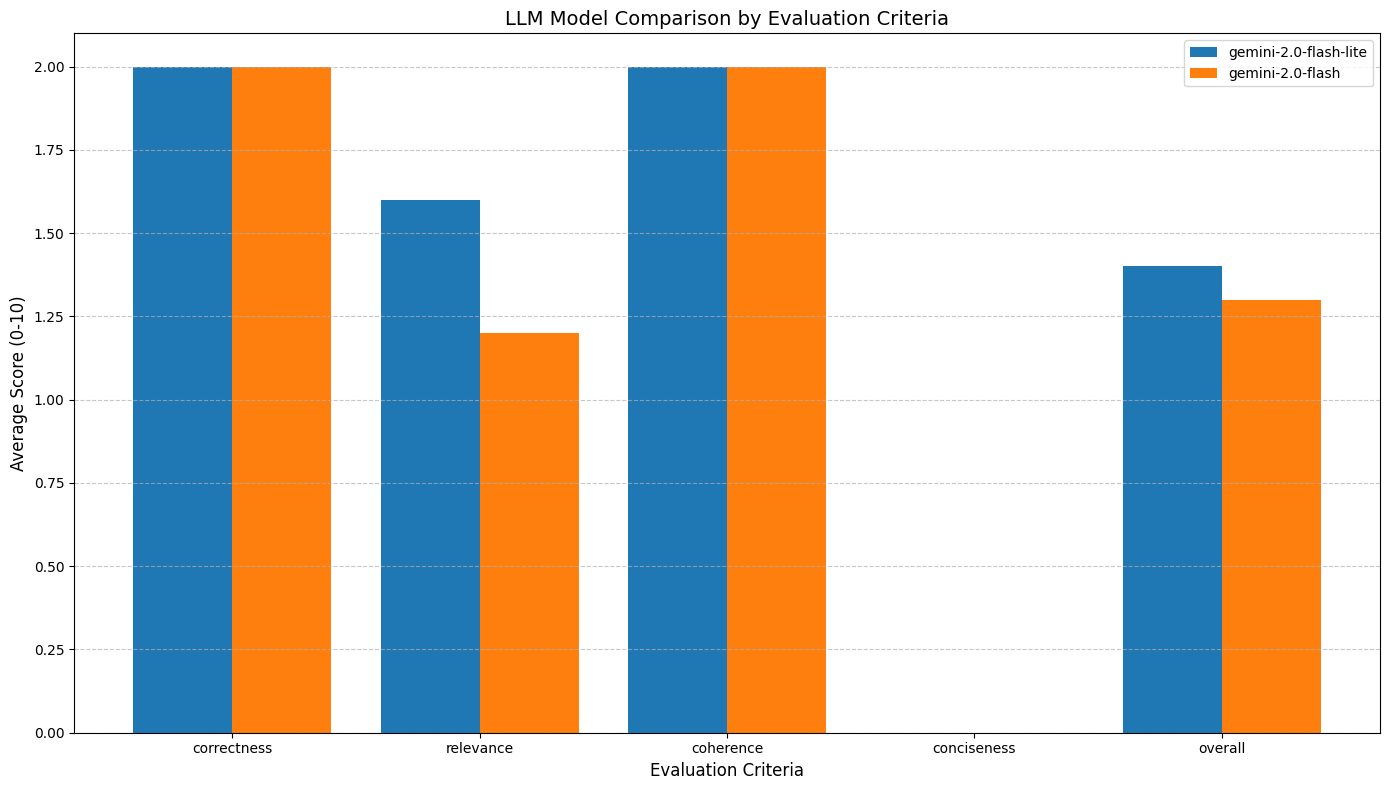

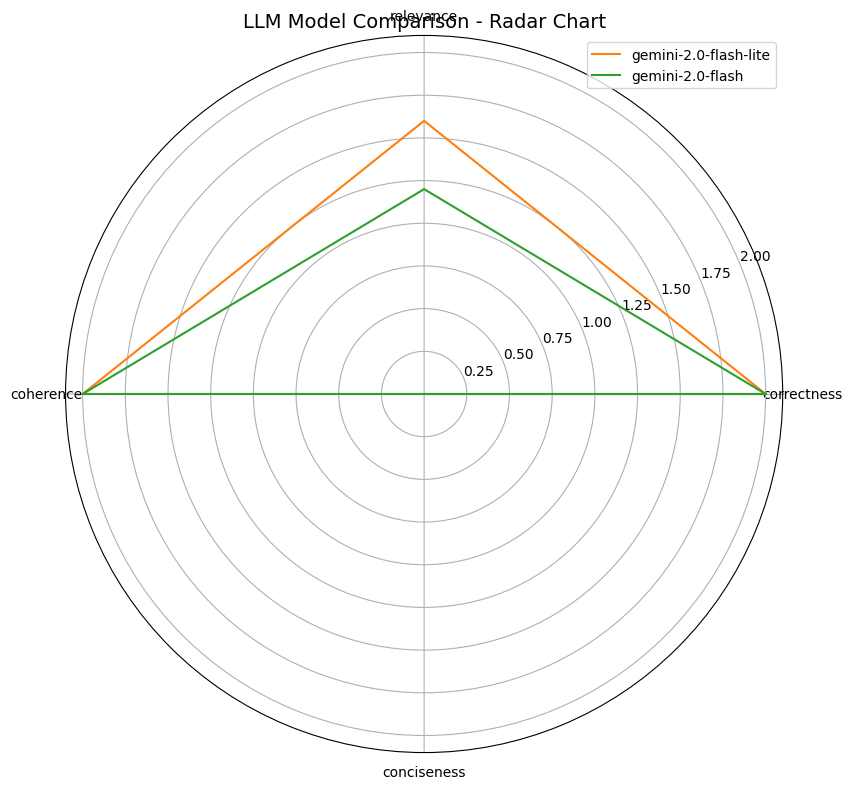


Performing pairwise model comparison...


<ipython-input-26-76f3ff707776>:26: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  pairwise_chain = LLMChain(llm=evaluator_model, prompt=pairwise_prompt)
<ipython-input-26-76f3ff707776>:39: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  comparison_result = pairwise_chain.run(



Pairwise comparison results:

gemini-2.0-flash-lite vs gemini-2.0-flash:
  Question 1: What are effective strategies for recent graduates to find entry-level positions?
  Analysis: **Response A Analysis:**

*   **Strengths:**
    *   Comprehensive and well-organized. Covers a wide...
  Question 2: How can I tailor my resume for a software engineering internship?
  Analysis: Response A:
*   **Strengths:**
    *   Provides a clear, step-by-step guide to tailoring a resume.
 ...

gemini-2.0-flash vs gemini-2.0-flash-lite:

Saving all results...
All results saved to CSV files.


<ipython-input-27-928988c672f9>:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{"Model": model, "Criterion": criterion, "Score": score}])],


In [28]:
if __name__ == "__main__":
    enhanced_main()